## Ingest images
Images of each deer are roughly square, and stored in a local folder. The images are ingested via `glob` and files that do not contain year information is removed. Once ingested, resized, and stacked, the labels are extracted from each images based on their filename.

In [1]:
from glob import glob
from generic.analysis.basics import extract_labels
from generic.analysis.basics import ingest_resize_stack

# Find/ingest files in folder; force square & b/w
files = glob("..\\images\\squared\\*.png")
files = [s for s in files if "xpx" not in s]
print(len(files), "images found")

# Ingest images
images = ingest_resize_stack(files)
_,_,_,ages,_ = extract_labels(files)
print('Sample size:', images.shape)

40 images found
Sample size: (40, 288, 288)


## Split datasets
The image stack is then split into training and test data, with a split of 80/20 -- 80% of the data resides in the training set, while the remaining 20% defines the test data. The training and test data are then normalized, and the labels for each dataset are cast to categorical values instead of their age values.

The validation data is then extracted from the training dataset, again in an 80/20 split -- 80% of the previous training data remains within the training dataset, and 20% is redefined as the validation set. Each dataset (training, validation, and test) are reshaped based on their format of grayscale images.

In [2]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split

# Convert labels to integers from 0 to 5 for proper one-hot encoding
# Create a mapping from your floating-point labels to integers
label_mapping = {label: i for i, label in enumerate(np.unique(ages))}
print("Label mapping:", label_mapping)

# Apply the mapping to convert labels to integers
integer_labels = np.array([label_mapping[l] for l in ages])
print("Converted labels:", integer_labels)

# Use a regular train_test_split without stratification
X_train, X_test, y_train, y_test = train_test_split(
    images, integer_labels, test_size=0.2, random_state=42
)

# Check the distribution after splitting
print("\nTraining set label distribution:")
unique_train_labels = np.unique(y_train)
for label in unique_train_labels:
    count = np.sum(y_train == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples ({count/len(y_train)*100:.2f}%)")

print("\nTest set label distribution:")
unique_test_labels = np.unique(y_test)
for label in unique_test_labels:
    count = np.sum(y_test == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples ({count/len(y_test)*100:.2f}%)")

# Normalize the images
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

Label mapping: {np.float64(1.5): 0, np.float64(2.5): 1, np.float64(3.5): 2, np.float64(4.5): 3, np.float64(5.5): 4, np.float64(6.5): 5, np.float64(12.5): 6}
Converted labels: [1 1 2 1 2 3 4 6 4 4 2 4 0 2 4 1 1 3 0 4 1 4 1 2 0 3 1 3 1 2 1 2 0 1 2 4 5
 0 1 2]

Training set label distribution:
Label 0 (1.5): 3 samples (9.38%)
Label 1 (2.5): 9 samples (28.12%)
Label 2 (3.5): 8 samples (25.00%)
Label 3 (4.5): 3 samples (9.38%)
Label 4 (5.5): 7 samples (21.88%)
Label 5 (6.5): 1 samples (3.12%)
Label 6 (12.5): 1 samples (3.12%)

Test set label distribution:
Label 0 (1.5): 2 samples (25.00%)
Label 1 (2.5): 3 samples (37.50%)
Label 2 (3.5): 1 samples (12.50%)
Label 3 (4.5): 1 samples (12.50%)
Label 4 (5.5): 1 samples (12.50%)


In [3]:
# Get the number of classes
num_classes = len(label_mapping)

# One-hot encode labels BEFORE splitting into train/validation
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

# Reshape data to add channel dimension
X_train = X_train.reshape(X_train.shape[0], 288, 288, 1)
X_test = X_test.reshape(X_test.shape[0], 288, 288, 1)

# Create a validation set (without stratification)
X_train_orig, X_valid, y_train_orig, y_valid = train_test_split(
    X_train, y_train_onehot, test_size=0.2, random_state=42
)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Print original sizes
print("\nBefore augmentation:")
print(X_train_orig.shape[0], "train samples")
print(X_test.shape[0], "test samples")
print(X_valid.shape[0], "validation samples")

# Setup data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

# Method 2: Generate augmented data in advance
# Define how many augmented samples per original sample
augmentation_factor = 5  # This will multiply your dataset by this factor
num_to_generate = X_train_orig.shape[0] * augmentation_factor

# Initialize empty arrays for augmented data
augmented_images = []
augmented_labels = []

# Create augmented images batch by batch
batch_size = 32
generated_count = 0

# Create a flow from the original data (without shuffling)
aug_gen = datagen.flow(
    X_train_orig, 
    y_train_orig,
    batch_size=batch_size,
    shuffle=False  # Important: keep the same order as labels
)

while generated_count < num_to_generate:
    # Get the next batch
    x_batch, y_batch = next(aug_gen)
    
    # Add to our collections
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    
    # Update the count
    generated_count += len(x_batch)
    
    # Break if we've generated enough
    if generated_count >= num_to_generate:
        break

# Concatenate all batches
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

# Trim excess (due to batch size)
augmented_images = augmented_images[:num_to_generate]
augmented_labels = augmented_labels[:num_to_generate]

# Combine with original data
X_train_combined = np.concatenate([X_train_orig, augmented_images])
y_train_combined = np.concatenate([y_train_orig, augmented_labels])

# Print new sizes after augmentation
print("\nAfter augmentation:")
print("Original training samples:", X_train_orig.shape[0])
print("Augmented training samples:", augmented_images.shape[0])
print("Combined training samples:", X_train_combined.shape[0])
print("Augmentation multiplier:", X_train_combined.shape[0] / X_train_orig.shape[0])
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined shape:", y_train_combined.shape)


Before augmentation:
25 train samples
8 test samples
7 validation samples

After augmentation:
Original training samples: 25
Augmented training samples: 125
Combined training samples: 150
Augmentation multiplier: 6.0
X_train_combined shape: (150, 288, 288, 1)
y_train_combined shape: (150, 7)


## Build network
With the data formatted and separated, we can now build the CNN.

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(288, 288, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 288, 288, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 144, 144, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 144, 144, 32)        │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 72, 72, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │      41,472,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,486,503 (158.26 MB)

 Trainable params: 41,486,503 (158.26 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from keras.callbacks import ModelCheckpoint

# Train with pre-generated augmented data
checkpointer = ModelCheckpoint(filepath='model_augmented.weights.best.hdf5.keras', 
                             verbose=1, save_best_only=True)

print("\nTraining with pre-generated augmented data:")
hist_augmented = model.fit(
    X_train_combined, 
    y_train_combined,
    batch_size=32,
    epochs=20,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpointer],
    verbose=1,
    shuffle=True
)


Training with pre-generated augmented data:
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.1925 - loss: 1.9045
Epoch 1: val_loss improved from inf to 1.97243, saving model to model_augmented.weights.best.hdf5.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.1916 - loss: 1.8951 - val_accuracy: 0.1429 - val_loss: 1.9724
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3223 - loss: 1.7746
Epoch 2: val_loss improved from 1.97243 to 1.94029, saving model to model_augmented.weights.best.hdf5.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3219 - loss: 1.7730 - val_accuracy: 0.1429 - val_loss: 1.9403
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.2886 - loss: 1.7134
Epoch 3: val_loss improved from 1.94029 to 1.79284, saving model to model_augmented.weights.best.hdf5.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2905 - loss: 1.7160 - val_accuracy: 0.1429 - val_loss: 1.7928
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/st

Comprehensive Class Evaluation:
 Class Index  Original Label  In Test Set  In Predictions  Precision  Recall  F1 Score
           0             1.5         True           False        NaN     NaN       NaN
           1             2.5         True            True      0.375     1.0  0.545455
           2             3.5         True           False        NaN     NaN       NaN
           3             4.5         True           False        NaN     NaN       NaN
           4             5.5         True           False        NaN     NaN       NaN
           5             6.5        False           False        NaN     NaN       NaN
           6            12.5        False           False        NaN     NaN       NaN


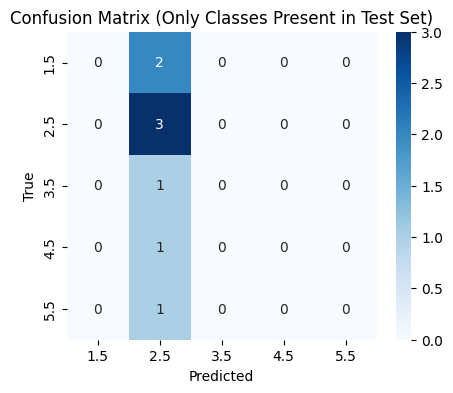


Overall Test Accuracy: 0.3750


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Evaluate with the best weights
model.load_weights('model_augmented.weights.best.hdf5.keras')

# Create a reverse mapping to get original labels
reverse_mapping = {i: label for label, i in label_mapping.items()}

# Make predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Create a comprehensive evaluation table that includes all classes
all_classes = list(range(num_classes))
all_class_names = [reverse_mapping[i] for i in all_classes]

# Create a comprehensive DataFrame
results_df = pd.DataFrame({
    'Class Index': all_classes,
    'Original Label': all_class_names,
    'In Test Set': [i in y_true for i in all_classes],
    'In Predictions': [i in y_pred for i in all_classes]
})

# Add metrics where applicable
precision_values = []
recall_values = []
f1_values = []
for cls in all_classes:
    if cls in y_true and cls in y_pred:
        # We can calculate metrics for this class
        true_binary = (y_true == cls).astype(int)
        pred_binary = (y_pred == cls).astype(int)
        precision_values.append(precision_score(true_binary, pred_binary, zero_division=0))
        recall_values.append(recall_score(true_binary, pred_binary, zero_division=0))
        f1_values.append(f1_score(true_binary, pred_binary, zero_division=0))
    else:
        # Class not present in test set or predictions
        precision_values.append(float('nan'))
        recall_values.append(float('nan'))
        f1_values.append(float('nan'))

results_df['Precision'] = precision_values
results_df['Recall'] = recall_values
results_df['F1 Score'] = f1_values

print("Comprehensive Class Evaluation:")
print(results_df.to_string(index=False))

# Create a confusion matrix (will only show classes present in test set)
cm = confusion_matrix(y_true, y_pred)
present_classes = sorted(set(np.concatenate([y_true, y_pred])))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f"{reverse_mapping[i]}" for i in present_classes],
           yticklabels=[f"{reverse_mapping[i]}" for i in present_classes])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Only Classes Present in Test Set)')
plt.show()

# Show overall accuracy
accuracy = np.mean(y_pred == y_true)
print(f"\nOverall Test Accuracy: {accuracy:.4f}")